In [2]:
%pip install --upgrade jupyter ipywidgets
%pip install matplotlib
%pip install scikit-learn
%pip install contractions
%pip install sentence_transformers
%pip install nltk
%pip install wordcloud
%pip install joblib
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install --upgrade transformers
%pip install torch torchvision torchaudio
%pip install seaborn
%pip install rake_nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
from threadpoolctl import threadpool_limits
import contractions

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation

#from joblib import threadpool_limits

import torch
print(torch.__version__)
from torch import nn
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import string


2.2.2


[nltk_data] Downloading package stopwords to /Users/yfd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Suppress warnings to avoid unnecessary output
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
## Load Data

In [ ]:
data = pd.read_pickle("/Users/yfd/Downloads/motley-fool-data.pkl")

In [ ]:
## Filter Data Based on SNP100 List

In [ ]:
# Extract the list of tickers from SNP100
snp100_tickers = SNP100['Symbol'].unique()

# Filter 'data' to include only rows where 'ticker' is in SNP100
filtered_data=data[data['ticker'].isin(snp100_tickers)]

# Save the filtered dataset if needed
filtered_data.to_csv("/Users/yfd/Downloads/filtered_data.csv", index=False)

print(filtered_data.head())

In [12]:
filtered_data = pd.read_csv("/Users/yfd/Downloads/filtered_data.csv")

In [ ]:
## Extract the speeches from participant in the "call participants"

In [13]:
# Make a copy of filtered_data to avoid SettingWithCopyWarning
filtered_data = filtered_data.copy()

# Function to extract participants and exclude certain ones
def extract_participants_and_exclude(transcript):
    # Regular expression to capture participants under "Call participants"
    participants_pattern = r"Call participants:\n(.*?)(?=\nMore|\nAll|\Z)"
    
    # Find participants using the pattern
    match = re.search(participants_pattern, transcript, re.DOTALL)
    if match:
        participants_text = match.group(1)
        
        # Split participants into a list
        participants_list = participants_text.strip().split("\n")
        
        # Filter out participants with company names (if more than two parts)
        included_participants = [participant for participant in participants_list if len(participant.split(" -- ")) == 2]
        excluded_participants = [participant for participant in participants_list if len(participant.split(" -- ")) != 2]
        
        return included_participants, excluded_participants
    else:
        return [], []

# Apply the function to the 'transcript' column
filtered_data[['participants', 'excluded_participants']] = filtered_data['transcript'].apply(
    lambda x: pd.Series(extract_participants_and_exclude(x))
)


In [14]:
def extract_speech(transcript, participants, excluded_participants):
    extracted_speech = {}

    # Define a regex to match any participant's speech until another participant's name or excluded names
    for participant in participants:
        # Build a dynamic regex pattern
        delimiters = participants + excluded_participants + ["Questions and Answers", "Operator"]
        delimiter_pattern = '|'.join([re.escape(d) for d in delimiters])
        pattern = re.compile(rf"({re.escape(participant)})\s*(.*?)(?=\n(?:{delimiter_pattern}|$))", re.DOTALL)
        
        # Find all matches for this participant's speech
        matches = pattern.findall(transcript)
        
        # If matches are found, clean the speech by removing other participants' names
        if matches:
            participant_speech = [match[1].strip() for match in matches]
            for other_participant in participants + excluded_participants:
                if other_participant != participant:
                    participant_speech = [re.sub(rf"\b{re.escape(other_participant)}\b", "", speech) for speech in participant_speech]
            extracted_speech[participant] = participant_speech
        else:
            extracted_speech[participant] = ["No speech found."]
    
    return extracted_speech

# Function to apply extract_speech to each row
def extract_speech_from_df(df):
    df['extracted_speech'] = df.apply(lambda row: extract_speech(row['transcript'], row['participants'], row['excluded_participants']), axis=1)
    return df


# Apply the function to the DataFrame
filtered_data = extract_speech_from_df(filtered_data)

In [15]:
print(filtered_data.columns)

Index(['date', 'exchange', 'q', 'ticker', 'transcript', 'participants',
       'excluded_participants', 'extracted_speech'],
      dtype='object')


In [ ]:
## Display the filtered data

In [19]:
filtered_data.describe()

,date,exchange,q,ticker,transcript,participants,excluded_participants,extracted_speech
count,1029,1029,1029,1029,1029,1029,1029,1029
unique,668,96,24,96,779,612,768,773
top,"Jul 22, 2020, 6:00 p.m. ET",NASDAQ: AAPL,2020-Q2,AAPL,Prepared Remarks:\nOperator\nLadies and gentle...,[Martin Viecha -- Senior Director for Investor...,"[Dan Levy -- Credit Suisse -- Analyst, Toni Sa...",{'Martin Viecha -- Senior Director for Investo...
freq,32,62,111,62,32,32,32,32


In [ ]:
## Perform Sentiment Analysis by FineBert Pipeline to Tokenize the Transcripts by Sentences

In [ ]:
from tqdm import tqdm
nltk.download('punkt_tab')
# Initialize the FinBERT sentiment analysis pipeline
finbert_pipeline = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone", tokenizer="yiyanghkust/finbert-tone")

# Number of rows per batch
batch_size = 100

# Initialize an empty list to store non-neutral sentences
non_neutral_sentences = []

# Define a function to process a batch of unique rows
def process_batch(batch_start, batch_end):
    batch_data = unique_filtered_data.iloc[batch_start:batch_end]  # Slice the unique DataFrame for the current batch

    for index, row in batch_data.iterrows():
        # Get the transcript of the current row
        extracted_speech = row['extracted_speech']  # Dictionary of participants and their transcripts

        # Iterate over each participant and their respective transcript
        for participant, transcript_list in extracted_speech.items():
            # Split the transcript into sentences
            sentences = nltk.sent_tokenize(" ".join(transcript_list))  # Join all the sentences in the list for this participant

            # Run sentiment analysis on each sentence using the FinBERT model
            sentiment_results = finbert_pipeline(sentences)

            # Filter out neutral sentences and save the non-neutral ones
            for i, result in enumerate(sentiment_results):
                if result['label'] != 'neutral':  # Only keep non-neutral sentences
                    non_neutral_sentences.append({
                        'sentence': sentences[i],
                        'label': result['label'],
                        'score': result['score'],
                        'participant': participant,  # Add participant information
                        'ticker': row['ticker']  # Add ticker information
                    })

# Remove duplicate rows based on 'extracted_speech'
unique_filtered_data = filtered_data.drop_duplicates(subset=['extracted_speech'])

# Process the unique data in batches with progress bar
total_rows = len(unique_filtered_data)
with tqdm(total=total_rows, desc="Processing unique batches", unit="row") as pbar:
    for start_row in range(0, total_rows, batch_size):
        end_row = min(start_row + batch_size, total_rows)  # Ensure we don't exceed the DataFrame size
        process_batch(start_row, end_row)  # Process the current batch
        pbar.update(batch_size)  # Update the progress bar

# Convert the list of non-neutral sentences to a DataFrame for easier inspection
non_neutral_sentences_df = pd.DataFrame(non_neutral_sentences)

# Save the results to a CSV file if needed
non_neutral_sentences_df.to_csv("/Users/yfd/Downloads/non_neutral_sentences (1).csv", index=False)

# Display the first few rows of the non-neutral sentences DataFrame
print(non_neutral_sentences_df.head())


In [ ]:
## For the sentimental analysis, we did it in colab by gpu then saved the results in the non_neutral_sentences dataset

In [16]:
sentiment_data = pd.read_csv("/Users/yfd/Downloads/non_neutral_sentences (1).csv")

In [17]:
print(sentiment_data.columns)

Index(['sentence', 'label', 'score', 'participant', 'ticker'], dtype='object')


In [18]:
## Add the q(year_quarter) of sentence in the sentiment_data dataset by merging it with the "Filtered_data" by 'Transcript', 'Sentence' and 'Participants'

In [19]:

def get_q_from_transcript(sentiment_data, filtered_data):
    q_values = []
    
    # Ensure that columns are strings
    filtered_data['transcript'] = filtered_data['transcript'].astype(str).str.lower().str.strip()
    sentiment_data['sentence'] = sentiment_data['sentence'].astype(str).str.lower().str.strip()
    filtered_data['participants'] = filtered_data['participants'].astype(str).str.lower().str.strip()
    
    # Iterate over each sentence in the sentiment_data dataset
    for index, row in sentiment_data.iterrows():
        participant = row['participant'].strip().lower()
        ticker = row['ticker'].strip().lower()
        sentence = row['sentence']
        
        # Find the matching rows in filtered_data based on 'participant' and 'ticker'
        matching_rows = filtered_data[
            (filtered_data['ticker'].str.lower() == ticker) & 
            (filtered_data['participants'].str.contains(participant))
        ]
        
        # Iterate through the matching rows to find the sentence within the transcript
        found_q = None
        for _, filtered_row in matching_rows.iterrows():
            if sentence in filtered_row['transcript']:  # check for partial match
                found_q = filtered_row['q']
                break
        
        q_values.append(found_q)
    
    # Add the 'q' column to the sentiment_data dataset
    sentiment_data['q'] = q_values
    return sentiment_data

# Example usage
sentiment_merged = get_q_from_transcript(sentiment_data, filtered_data)

sentences_merged.to_csv("/Users/yfd/Downloads/sentences_merged.csv", index=False)

In [ ]:
## Display new merged dataset

In [21]:
sentiment_merged = pd.read_csv("/Users/yfd/Downloads/sentences_merged.csv")

In [22]:
sentiment_merged

,sentence,label,score,participant,ticker,q
0,"good morning, ladies and gentlemen, and welcom...",Neutral,0.999439,Gerald Gradwell -- Senior Vice President of In...,WBA,2021-Q3
1,"on the call with me today are roz brewer, the ...",Neutral,0.999990,Gerald Gradwell -- Senior Vice President of In...,WBA,2021-Q3
2,before i hand you over to roz to make some ope...,Neutral,0.997839,Gerald Gradwell -- Senior Vice President of In...,WBA,2021-Q3
3,certain statements and projections of future r...,Neutral,0.980985,Gerald Gradwell -- Senior Vice President of In...,WBA,2021-Q3
4,we undertake no obligation to update publicly ...,Neutral,0.998404,Gerald Gradwell -- Senior Vice President of In...,WBA,2021-Q3
...,...,...,...,...,...,...
319372,we're building nvidia ai and nvidia omniverse ...,Positive,0.995862,Jensen Huang -- President and Chief Executive ...,NVDA,2023-Q2
319373,"i look forward to next month's gtc conference,...",Positive,0.999911,Jensen Huang -- President and Chief Executive ...,NVDA,2023-Q2
319374,so join us.,Neutral,0.997636,Jensen Huang -- President and Chief Executive ...,NVDA,2023-Q2
319375,we look forward to updating you on our progres...,Neutral,0.999664,Jensen Huang -- President and Chief Executive ...,NVDA,2020-Q2


In [ ]:
## Display the top 10 negative sentences by each transcript and show its 'speaker name' and 'speak title' and 'score' and 'label'

In [51]:
import pandas as pd

def split_participant_and_process_title(sentiment_merged):
    # Split the 'participant' column into 'speaker name' and 'speaker title'
    sentiment_merged[['speaker name', 'speaker title']] = sentiment_merged['participant'].str.split(' -- ', expand=True)

    # Simplify the speaker title based on conditions
    sentiment_merged['speaker title'] = sentiment_merged['speaker title'].apply(
        lambda title: 'CEO' if 'Chief Executive Officer' in title else 
                      ('CFO' if 'Chief Financial Officer' in title else 'Else')
    )
    
    return sentiment_merged

def get_top_negative_sentences(sentiment_merged):
    # Apply the function to split 'participant' and process the title
    sentiment_merged = split_participant_and_process_title(sentiment_merged)

    # Create a new combined column 'ticker_q' that combines 'ticker' and 'q'
    sentiment_merged['ticker_q'] = sentiment_merged['ticker'] + '_' + sentiment_merged['q'].astype(str)

    # Create an empty list to store the results
    top_negative_sentences = []

    # Group by the combined column 'ticker_q'
    for ticker_q, group in sentiment_merged.groupby('ticker_q'):
        # Filter only negative sentences and sort them by 'score' in descending order
        negative_sentences = group[group['label'] == 'Negative'].sort_values(by='score', ascending=False).head(10)

        # Append top 5 negative sentences
        for _, row in negative_sentences.iterrows():
            top_negative_sentences.append({
                'label': row['label'],
                'score': row['score'],
                'speaker name': row['speaker name'],
                'speaker title': row['speaker title'],
                'q': row['q'],
                'ticker': row['ticker'],
                'sentiment': 'Negative',
                'sentence': row['sentence']
            })

    # Create a DataFrame from the top negative sentences list
    top_negative_sentences_df = pd.DataFrame(top_negative_sentences)
    return top_negative_sentences_df

# Example usage
top_negative_sentences = get_top_negative_sentences(sentiment_merged)

# Show the first few rows of the top_negative_sentences DataFrame
top_negative_sentences.head()


,label,score,speaker name,speaker title,q,ticker,sentiment,sentence
0,Negative,1.000000,Luca Maestri,CFO,2019-Q3,AAPL,Negative,"products gross margin was 30.4%, down about 80..."
1,Negative,1.000000,Luca Maestri,CFO,2019-Q3,AAPL,Negative,"iphone revenue was $26 billion, down 12% compa..."
2,Negative,0.999980,Luca Maestri,CFO,2019-Q3,AAPL,Negative,"on the negative side, the headwind on gross ma..."
3,Negative,0.999923,Tim Cook,CEO,2019-Q3,AAPL,Negative,"and i apologize for my voice, i'm suffering fr..."
4,Negative,0.999911,Luca Maestri,CFO,2019-Q3,AAPL,Negative,this guidance includes almost $1 billion of th...


In [52]:
top_negative_sentences['sentence']

0       products gross margin was 30.4%, down about 80...
1       iphone revenue was $26 billion, down 12% compa...
2       on the negative side, the headwind on gross ma...
3       and i apologize for my voice, i'm suffering fr...
4       this guidance includes almost $1 billion of th...
                              ...                        
7560    and, obviously, it's challenged in the chemica...
7561    it's -- i think you hit on a very good point, ...
7562    and so, like a lot of the parts of our busines...
7563    and price timing impacts, and again, i would h...
7564    and instead, what's been put in place is a pen...
Name: sentence, Length: 7565, dtype: object

In [25]:
## Show the number and percentage of sentences by title

In [26]:
def count_negative_sentences_by_title(sentiment_merged):
   
    # Count the number of negative sentences per title
    counts = top_negative_sentences['speaker title'].value_counts()

    # Calculate the percentage of negative sentences per title
    percentages = (counts / counts.sum()) * 100

    # Combine counts and percentages into a single DataFrame
    summary_df = pd.DataFrame({
        'title': counts.index,
        'count': counts.values,
        'percentage': percentages.values
    })

    return summary_df

# Example usage
negative_summary = count_negative_sentences_by_title(sentiment_merged)

# Display the results
negative_summary



,title,count,percentage
0,CFO,4212,55.677462
1,CEO,2307,30.495704
2,Else,1046,13.826834


In [27]:
## Filter the over-negative sentences with score 1

In [74]:
def filter_negative_score_one(sentiment_merged):
    # Apply the function to split 'participant' and process the title
    sentiment_merged = split_participant_and_process_title(sentiment_merged)

    # Filter rows where label is 'Negative' and score equals 1
    negative_score_one = sentiment_merged[
        (sentiment_merged['label'] == 'Negative') & (sentiment_merged['score'] == 1)
    ]

    return negative_score_one

# Example usage
negative_score_one_df = filter_negative_score_one(sentiment_merged)

# Display the filtered sentences
negative_score_one_df[['sentence', 'label', 'score', 'speaker name', 'speaker title', 'ticker', 'q']]


,sentence,label,score,speaker name,speaker title,ticker,q
4704,this was below our expectations due to the sof...,Negative,1.0,Brian Newman,CFO,UPS,2021-Q4
14949,"ipad revenue was $7.2 billion, down 2% year ov...",Negative,1.0,Luca Maestri,CFO,AAPL,2022-Q3
20857,"revenue was $15.3 billion, 15% below our origi...",Negative,1.0,David Zinsner,CFO,INTC,2022-Q2
20869,"dcai revenue was $4.6 billion, below expectati...",Negative,1.0,David Zinsner,CFO,INTC,2022-Q2
20931,"and maybe i'll just add, in terms of profitabi...",Negative,1.0,David Zinsner,CFO,INTC,2022-Q2
44490,these results came in below the guidance we ga...,Negative,1.0,Christine McCarthy,CFO,DIS,2023-Q1
50313,now there were parts of the quarter that playe...,Negative,1.0,Geoff Martha,CEO,MDT,2022-Q4
50320,the shortfall to our revenue guidance was prim...,Negative,1.0,Geoff Martha,CEO,MDT,2022-Q4
50326,and this resulted in large back orders and cau...,Negative,1.0,Geoff Martha,CEO,MDT,2022-Q4
50631,our fourth quarter organic revenue increased 1...,Negative,1.0,Karen Parkhill,CFO,MDT,2022-Q4


In [93]:
negative_score_one_df['sentence'].iloc[2]

'revenue was $15.3 billion, 15% below our original q2 guidance as our ccg and dcai businesses both underperformed our expectations.'

In [94]:
negative_score_one_df['sentence'].iloc[3]

'dcai revenue was $4.6 billion, below expectations and down 16% year over year on oem inventory reductions, mix-related asp decline and competitive pressures.'

In [95]:
negative_score_one_df['sentence'].iloc[4]

"and maybe i'll just add, in terms of profitability, it was disappointing where operating margins landed for the dcai business for sure."

In [32]:
import yfinance as yf

# Define the ticker symbol
ticker_symbol = "AAPL"

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch historical market data
historical_data = ticker.history(period="1y")  # data for the last year
print("Historical Data:")
print(historical_data)

# Fetch basic financials
financials = ticker.financials
print("\nFinancials:")
print(financials)

# Fetch stock actions like dividends and splits
actions = ticker.actions
print("\nStock Actions:")
print(actions)

Historical Data:
                                 Open        High         Low       Close  \
Date                                                                        
2024-01-16 00:00:00-05:00  181.271952  183.361705  180.047938  182.734787   
2024-01-17 00:00:00-05:00  180.386299  182.038195  179.421026  181.789413   
2024-01-18 00:00:00-05:00  185.182793  188.217927  184.924066  187.710419   
2024-01-19 00:00:00-05:00  188.406990  191.014212  187.899482  190.626114   
2024-01-22 00:00:00-05:00  191.362503  194.377730  191.322690  192.944748   
...                               ...         ...         ...         ...   
2025-01-08 00:00:00-05:00  241.919998  243.710007  240.050003  242.699997   
2025-01-10 00:00:00-05:00  240.009995  240.160004  233.000000  236.850006   
2025-01-13 00:00:00-05:00  233.529999  234.669998  229.720001  234.399994   
2025-01-14 00:00:00-05:00  234.750000  236.119995  232.470001  233.279999   
2025-01-15 00:00:00-05:00  234.639999  238.539993  234.4299

In [75]:
financial_result = pd.read_csv("/Users/yfd/Downloads/financial_result.csv")

In [76]:
print(financial_result.columns)

Index(['Unnamed: 0', 'q', 'Symbol', 'clean_trans2', 'sentiment_pos',
       'sentiment_neg', 'sentiment_neu', 'date_minus_7', 'date_minus_1',
       'Date', 'date_plus_1', 'date_plus_7', '-7', '-1', '0', '1', '7', '28',
       'return -7 to -1', 'return-1 to 0', 'return 0 to 1', 'return 0 to 7',
       'return 0 to 28'],
      dtype='object')


In [87]:
merged_data = pd.merge(negative_score_one_df, financial_result, how='inner', left_on=['ticker', 'q'], right_on=['Symbol', 'q'])


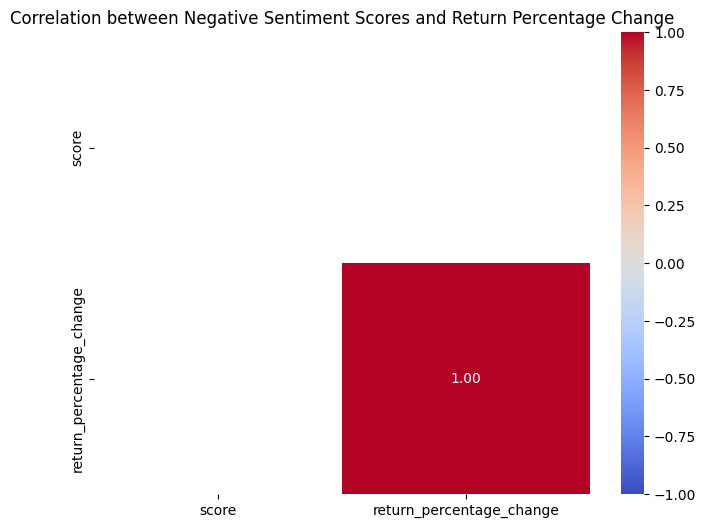

In [89]:
# Assuming top_negative_sentences contains sentences with 'ticker', 'score', and 'sentence' columns
# Assuming financial_result has columns 'Symbol' (for the ticker) and 'return 0 to 1', 'return -1 to 0'

# Step 1: Merge the top_negative_sentences with the financial_result on 'ticker' and 'Symbol'
merged_data = pd.merge(negative_score_one_df, financial_result, left_on='ticker', right_on='Symbol', how='inner')

# Step 2: Calculate the percentage change in return
merged_data['return_percentage_change'] = (merged_data['return 0 to 1'] - merged_data['return-1 to 0']) / merged_data['return-1 to 0']

# Step 3: Drop rows with NaN values in the relevant columns
merged_data_clean = merged_data.dropna(subset=['score', 'return_percentage_change'])

# Step 4: Calculate the correlation between sentiment score and percentage change in return
correlation = merged_data_clean[['score', 'return_percentage_change']].corr()

# Step 5: Plot the correlation matrix using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', cbar=True)
plt.title("Correlation between Negative Sentiment Scores and Return Percentage Change")
plt.show()


In [70]:
correlation

,score,return_percentage_change
score,1.000000,0.006166
return_percentage_change,0.006166,1.000000


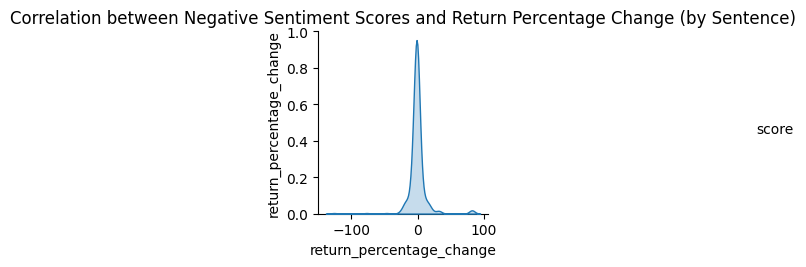

In [90]:
# Step 1: Merge top_negative_sentences with financial_result on 'ticker' and 'Symbol'
merged_data = pd.merge(negative_score_one_df, financial_result, left_on='ticker', right_on='Symbol', how='inner')

# Step 2: Calculate the percentage change in return for each sentence
merged_data['return_percentage_change'] = (merged_data['return 0 to 1'] - merged_data['return-1 to 0']) / merged_data['return-1 to 0']

# Step 3: Drop rows with NaN values in the relevant columns
merged_data_clean = merged_data.dropna(subset=['score', 'return_percentage_change'])

# Step 4: Calculate the correlation between sentiment score and percentage change for each sentence
correlation = merged_data_clean[['sentence', 'score', 'return_percentage_change']]

# Step 5: Visualize the correlation for each sentence using a pairplot to see how sentiment score correlates with return percentage change
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pairplot to visualize the relationships
sns.pairplot(correlation, hue='score', kind='scatter')
plt.title("Correlation between Negative Sentiment Scores and Return Percentage Change (by Sentence)")
plt.show()


In [58]:
# Remove rows with NaN or invalid values in relevant columns
merged_data = merged_data.dropna(subset=['return-1 to 0', 'return 0 to 1', 'score'])

# Remove rows where 'return -1 to 0' is zero, which would lead to division by zero
merged_data = merged_data[merged_data['return-1 to 0'] != 0]

# Calculate the percentage change in return between 'return 0 to 1' and 'return -1 to 0'
merged_data['return_percentage_change'] = (merged_data['return 0 to 1'] - merged_data['return-1 to 0']) / merged_data['return-1 to 0']

# Now calculate the correlation between the negative sentiment scores and the return percentage change
correlation = merged_data['score'].corr(merged_data['return_percentage_change'])

# Display the correlation result
print(f"Correlation between negative sentiment scores and return percentage change: {correlation:.4f}")

Correlation between negative sentiment scores and return percentage change: 0.0034
